In [1]:
# Housing Dataset
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data',
                header=None, sep='\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS',
             'NOX', 'RM', 'AGE', 'DIS', 'RAD',
             'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


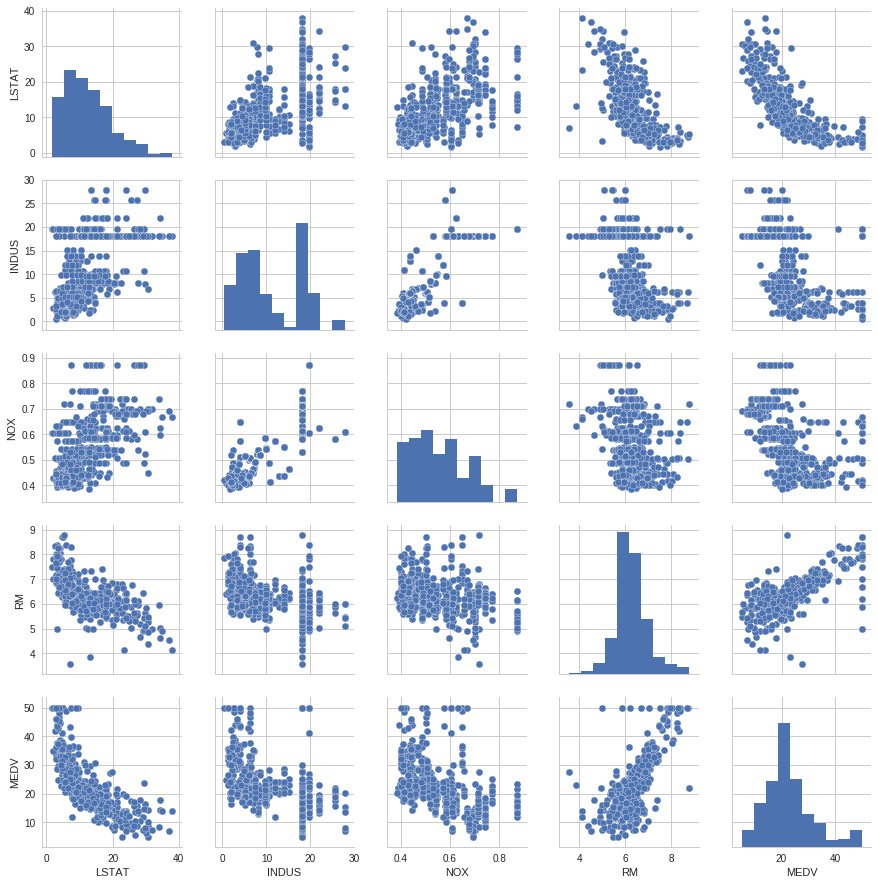

In [3]:
# Visualizing the important characteristics of a dataset

# scatterplot matrix to visualize pair-wise correlations between different features
# seaborn library - Python library for drawing statistical plots based on matplotlib

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
sns.pairplot(df[cols], size=2.5);
plt.show()

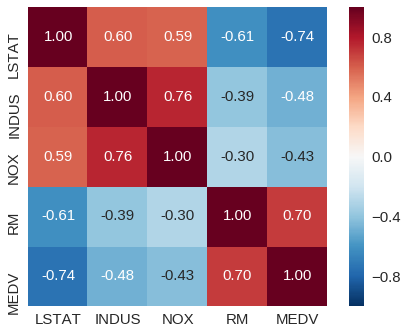

In [4]:
# Correlation Matrix 
# Contains Pearson product-moment correlation coefficients (Pearson's r), measures linear dependency between pairs
# of features.
# Bounded in range -1 and 1.
# Two features perfect positive correlation if r = 1, no correlation if r = 0 and 
# perfect negative correltaion if r = -1.
# Caclulated as covariance between two features x and y divided by the product of their standard deviation

# Plot correlation matrix as heat map:
import numpy as np
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 15}, yticklabels=cols, xticklabels=cols)
plt.show()

In [42]:
# Implementing ordinary least squares linear regression model (OLS)
# Estimate the parameters of the regression line that minimizes the sum of the squared vertical distances
# (residuals/errors) to the sample points.

# Solving regression for regression parameters with gradient descent

# Use RM (number of rooms) as explanatory variable to train a model that can predict MEDV (housing prices)
from linear_regression_gd import LinearRegressionGD

X = df[['RM']].values # nested array as only 1 feature per sample
y = df[['MEDV']].values
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y)
lr = LinearRegressionGD()
lr.fit(X_std, y_std.flatten())

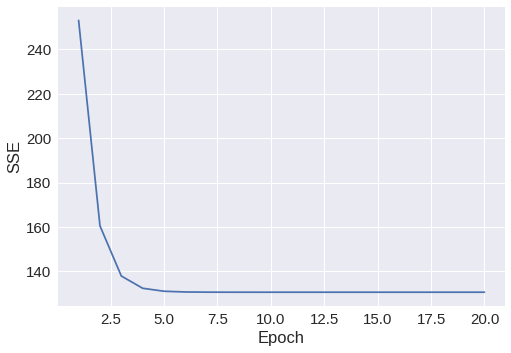

In [44]:
# Plot cost  as a function of the number of epochs (passes over the training dataset)
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

In [46]:
# Visualize how well the linear regression line fits the training data

# helper function
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='blue')
    plt.plot(X, model.predict(X), color='red')
    return None

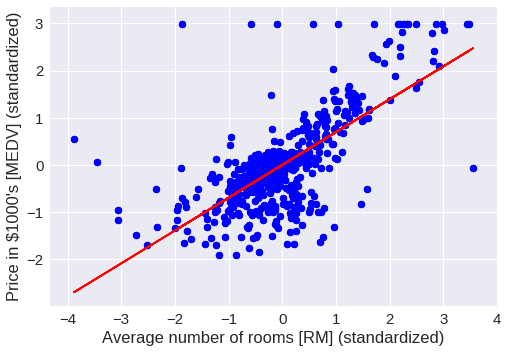

In [48]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000\'s [MEDV] (standardized)')
plt.show()

In [56]:
# In certain cases, may need to report predicted outcome variables on original scale
num_rooms_std = sc_x.transform([[5.0]]) # house with 5 rooms
price_std = lr.predict(num_rooms_std)
print("Price in $1000's: %.3f" % \
    sc_y.inverse_transform(price_std))

Price in $1000's: 10.840


In [57]:
# Note: do not have to update the weight of the intercept if working with standardied variables \
# since y intercept is always 0
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0])

Slope: 0.695
Intercept: -0.000


In [58]:
# Estimating the coefficient of a regression model via scikit-learn
# LIBLINEAR library
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept:%.3f' % slr.intercept_) # unstandardized variables

Slope: 9.102
Intercept:-34.671


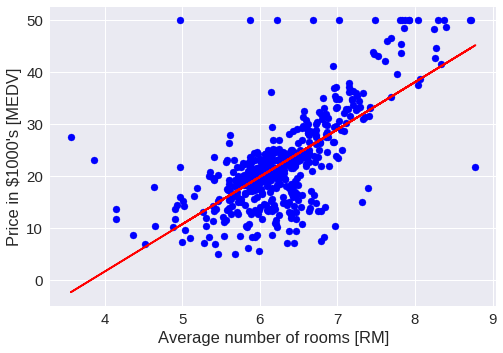

In [59]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.show()

In [71]:
# Fitting a robust regression model using RANSAC

# Linear regression models heavily impacted by the presence of outliers
# Random Sample Consensus (RANSAC) algorithm - fits regression model to subset of data (inliers)
# 1. Select random number of samples to be inliers and fit model
# 2. Test all other data ponts against fitted model and add those points that fall within a user-given tolerance
# to the inliers.
# 3. Refit the model using all inliers.
# 4. Estimate the error of the fitted model versus inliers
# 5. Terminate the algorithm if the performance meets a certain user-defined threshold or if a fixed number of
# iterations has been reached; go back to step 1 otherwise

from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(),
                        max_trials=100,
                        min_samples=50,
                        loss=lambda y, y_pred: np.sum(np.abs(y-y_pred), axis=1), # vertical distance btw fitted line and sample pts
                        residual_threshold=5.0, # only allow dist <= 5 from fitted line
                        random_state=0)
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None,
        loss=<function <lambda> at 0x7f4842da1a60>, max_trials=100,
        min_samples=50, random_state=0, residual_metric=None,
        residual_threshold=5.0, stop_n_inliers=inf, stop_probability=0.99,
        stop_score=inf)

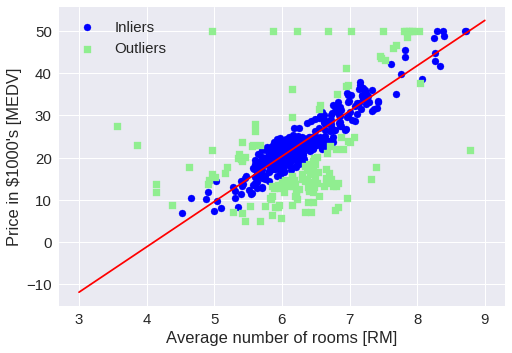

In [72]:
# plot inliers and outliers from fitted RANSAC linear regression model
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='blue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
           c='lightgreen', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper left')
plt.show()

In [73]:
# print slope and intercept
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089
